<img src="https://user-images.strikinglycdn.com/res/hrscywv4p/image/upload/c_limit,fl_lossy,h_300,w_300,f_auto,q_auto/1266110/Logo_wzxi0f.png" style="float: left; margin: 20px; height: 55px">

**Solo el que intenta el absurdo es capaz de lograr lo imposible - [Miguel de Unamuno](https://es.wikipedia.org/wiki/Miguel_de_Unamuno)**

Only who attempts the absurd is capable of achieving the impossible

# Chapter 12 Time Series Analysis

A **time series** is a sequence of measurements from a system that varies in time. One famous example is the “hockey stick graph” that shows global average temperature over time (see https://en.wikipedia.org/wiki/Hockey_stick_graph)

The example I work with in this chapter comes from Zachary M. Jones, a researcher in political science who studies the black market for cannabis in the U.S. (http://zmjones.com/marijuana). He collected data from a web site called “Price of Weed” that crowdsources market information by asking participants to report the price, quantity, quality, and location of cannabis transactions (http://www.priceofweed.com/). The goal of his project is to investigate the effect of policy decisions, like legalization, on markets. I find this project appealing because it is an example that uses data to address important political questions, like drug policy.

I hope you will find this chapter interesting, but I’ll take this opportunity to reiterate the importance of maintaining a professional attitude to data analysis. Whether and which drugs should be illegal are important and
difficult public policy questions; our decisions should be informed by accurate data reported honestly.

## Importing and cleaning

The data I downloaded from Mr. Jones’s site is in the repository for this book. The following code reads it into a pandas DataFrame:

In [4]:
import pandas as pd

In [5]:
transactions = pd.read_csv('Resources/Think_Stats/Thinkstats2/mj-clean.csv', parse_dates=[5])

`parse_dates` tells `read_csv` to interpret values in column 5 as dates and convert them to NumPy datetime64 objects.

Do some initial analysis at analysis on the dataset:

In [6]:
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [7]:
transactions[transactions['state'] == 'CA'].describe()

,price,amount,ppg,lat,lon
count,19989.000000,19989.000000,19989.000000,19987.000000,19987.000000
mean,125.140527,16.968546,8.641743,35.703325,-119.669288
std,107.515516,11.265342,4.847106,2.142205,2.106100
min,4.000000,1.000000,1.020000,32.652524,-124.162120
25%,50.000000,5.000000,5.300000,33.889502,-121.723568
50%,100.000000,14.150000,8.000000,34.524558,-118.905173
75%,190.000000,28.300000,11.300000,37.777208,-118.028619
max,950.000000,28.300000,34.630000,41.925752,-114.561905


In [4]:
transactions.describe(include = 'all')

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
count,147070,147070,147070.000000,147070.000000,147070,147070,147070.000000,147070,146897.000000,146897.000000
unique,7581,48,NaN,NaN,3,1243,NaN,48,NaN,NaN
top,Los Angeles,CA,NaN,NaN,high,2010-09-14 00:00:00,NaN,California,NaN,NaN
freq,2076,19989,NaN,NaN,76411,964,NaN,19989,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,2010-09-02 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2014-05-13 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,137.259516,15.336626,NaN,NaN,10.670560,NaN,37.858994,-91.988509
std,NaN,NaN,120.217590,11.145683,NaN,NaN,5.622977,NaN,5.008867,16.545298
min,NaN,NaN,4.000000,1.000000,NaN,NaN,1.020000,NaN,24.675731,-124.399110
25%,NaN,NaN,50.000000,5.000000,NaN,NaN,6.000000,NaN,33.990380,-104.804560


The dataset has the following columns:

- city: string city name.
- state: two-letter state abbreviation.
- price: price paid in dollars.
- amount: quantity purchased in grams.
- quality: high, medium, or low quality, as reported by the purchaser.
- date: date of report, presumed to be shortly after date of purchase.
- ppg: price per gram, in dollars.
- state.name: string state name.
- lat: approximate latitude of the transaction, based on city name.
- lon: approximate longitude of the transaction.

Each transaction is an event in time, so we could treat this dataset as a time series. But the events are not equally spaced in time; the number of transactions reported each day varies from 0 to several hundred. Many
methods used to analyze time series require the measurements to be equally spaced, or at least things are simpler if they are.

Divide the dataset into groups by average reported quality. Use the python groupby method:

In [7]:
groups = transactions.groupby('quality')

Create a result Dataframes with average price per day for each quality:

In [13]:
transactions.groupby(['quality','date'])['price'].mean()

quality  date      
high     2010-09-02    157.906977
         2010-09-03    127.731959
         2010-09-04    190.833333
         2010-09-05    146.500000
         2010-09-06     67.500000
                          ...    
medium   2014-05-09     92.058824
         2014-05-10    126.274510
         2014-05-11     99.142857
         2014-05-12    114.586207
         2014-05-13    114.737500
Name: price, Length: 3658, dtype: float64

## Plotting

Using your knowledge of Matplotlib plot a scaterplot of the series of quality:

In [19]:
import matplotlib.pylab as plt
import seaborn as sns

In [17]:
transactions.quality.unique()

array(['high', 'medium', 'low'], dtype=object)

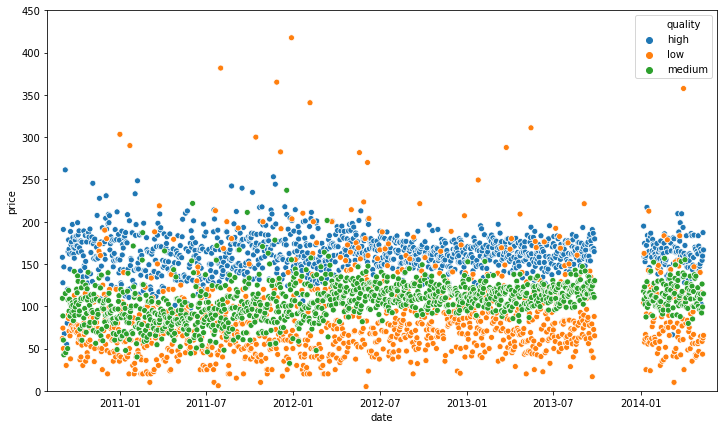

In [29]:
plt.figure(figsize = (12,7))
sns.scatterplot(data=transactions.groupby(['quality','date'])['price'].mean().reset_index(),
                x='date', y='price', hue='quality')
plt.ylim(0, 450)
plt.xlim('2010-08-01','2014-06-10')
plt.show()

## Linear Regression

Although there are methods specific to time series analysis, for many problems a simple way to get started is by applying general-purpose tools like linear regression. 
Create a function that takes a DataFrame of daily prices and computes a least squares fit, returning the model and results objects from `StatsModels`:

In [56]:
from Resources.Think_Stats.Thinkstats2 import thinkstats2
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import datetime
pd.options.display.max_columns = 100

In [32]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [42]:
df_high = transactions[transactions.quality == 'high'].reset_index(drop=True)

In [43]:
df_high['date_2'] = pd.to_datetime(df_high['date']).dt.date 

In [44]:
df_high['date_diff'] = (df_high['date_2'] - datetime.datetime.now().date()).dt.days

In [36]:
df_high['date_diff'] = -df_high['date_diff']/365

In [37]:
formula = 'price ~ date_diff'
model = smf.ols(formula, data=df_high)
results = model.fit()
inter = results.params['Intercept']
slope = results.params['date_diff']
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     4.254
Date:                Mon, 09 Dec 2019   Prob (F-statistic):             0.0394
Time:                        15:17:10   Log-Likelihood:                -5642.2
No. Observations:                1241   AIC:                         1.129e+04
Df Residuals:                    1239   BIC:                         1.130e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    171.3870      4.780     35.853      0.000     162.009     180.765
date_diff     -1.2959      0.628     -2.063      0.039      -2.528      -0.063
==============================================================================
Omnibus:                       72.961   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              282.448
Skew:                          -0.071   Prob(JB):                     4.65e-62
Kurtosis:                       5.333   Cond. No.                         57.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

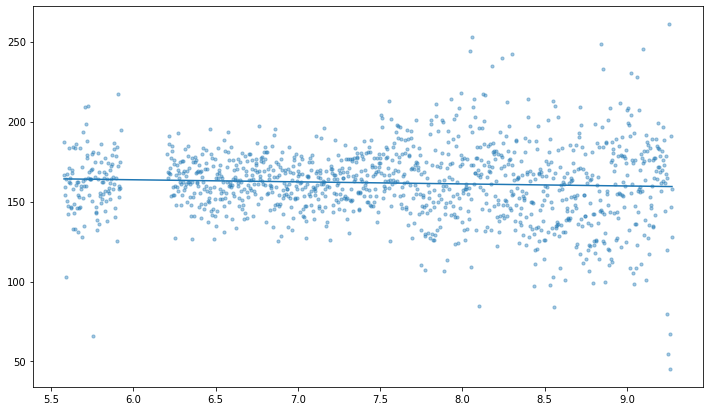

In [38]:
dates = df_high.date_diff
prices = df_high.price
fit_xs, fit_ys = FitLine(dates, inter, slope)
plt.figure(figsize=(12,7))
plt.scatter(dates, prices, s=10, alpha=0.4)
plt.plot(fit_xs, fit_ys)
plt.show()

What do you see:

In [165]:
# Answer here

The model seems like a good linear fit for the data; nevertheless, linear regression is not the most appropriate choice for this data:

- First, there is no reason to expect the long-term trend to be a line or any other simple function. In general, prices are determined by supply and demand, both of which vary over time in unpredictable ways.

- Second, the linear regression model gives equal weight to all data, recent and past. For purposes of prediction, we should probably give more weight to recent data.

- Finally, one of the assumptions of linear regression is that the residuals are uncorrelated noise. With time series data, this assumption is often false because successive values are correlated.

The next section presents an alternative that is more appropriate for time series data.

## Moving Averages

Most time series analysis is based on the modeling assumption that the observed series is the sum of **three components**:

- Trend: A smooth function that captures persistent changes.
- Seasonality: Periodic variation, possibly including daily, weekly, monthly, or yearly cycles.
- Noise: Random variation around the long-term trend.

Regression is one way to extract the trend from a series, as we saw in the previous section. But if the trend is not a simple function, a good alternative is a **moving average**. A moving average divides the series into overlapping regions, called **windows**, and computes the average of the values in each window.

One of the simplest moving averages is the **rolling mean**, which computes the mean of the values in each window. For example, if the window size is 3, the rolling mean computes the mean of values 0 through 2, 1 through 3, 2
through 4, etc.

pandas provides rolling_mean, which takes a Series and a window size and returns a new Series.

Calculate and plot the rolling mean with a window of size 2,5,15, 30 and 60 and for each of the values series:

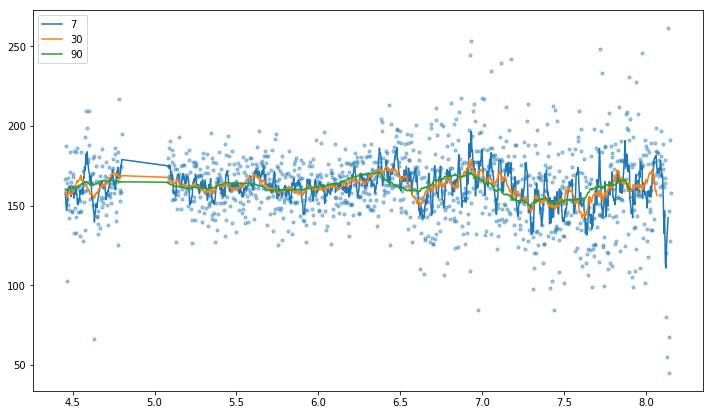

In [192]:
movingmean = []
plt.figure(figsize=(12,7))
for w in [7, 30, 90]:
    df_high_p = df_high['price'].rolling(w).mean()
    df_high_p.index = dates
    plt.plot(df_high_p, label = w)
    plt.legend()
    
plt.scatter(dates, prices, s=10, alpha=0.4)
plt.show()

An alternative is the **exponentially-weighted moving average (EWMA)**, which has two advantages. First, as the name suggests, it computes a weighted average where the most recent value has the highest weight and the weights for previous values drop off exponentially. Second, the pandas implementation of EWMA handles missing values better.

Do the same implementation and plotting:

In [57]:
def GroupByDay(transactions, func=np.mean):
    """Groups transactions by day and compute the daily mean ppg.

    transactions: DataFrame of transactions

    returns: DataFrame of daily prices
    """
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)

    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year

    return daily

In [58]:
def GroupByQualityAndDay(transactions):
    """Divides transactions by quality and computes mean daily price.

    transaction: DataFrame of transactions
    
    returns: map from quality to time series of ppg
    """
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)        

    return dailies

In [59]:
dailies = GroupByQualityAndDay(transactions)

In [60]:
from Resources.Think_Stats.Thinkstats2 import thinkplot

In [61]:
def PlotEWMA(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = pd.ewma(reindexed.ppg, 30)
    thinkplot.Plot(roll_mean, label='EWMA', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='price per gram ($)')

In [62]:
name = 'high'
daily = dailies[name]

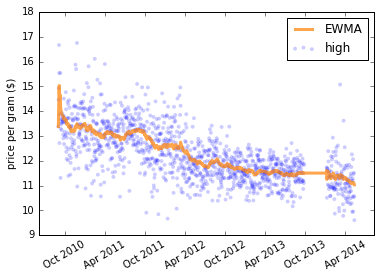

In [17]:
PlotEWMA(daily, name)

The span parameter corresponds roughly to the window size of a moving average; it controls how fast the weights drop off, so it determines the number of points that make a non-negligible contribution to each average.

The values are noisy at the beginning of
the time series, because they are based on fewer data points.

## Missing values

Now that we have characterized the trend of the time series, the next step is to investigate seasonality, which is periodic behavior. Time series data based on human behavior often exhibits daily, weekly, monthly, or yearly cycles. In the next section I present methods to test for seasonality, but they don’t work well with missing data, so we have to solve that problem first.

A simple and common way to fill missing data is to use a moving average. The Series method fillna does just what we want. Fill the na in the dataframe with the average means you calculated before:

In [18]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pd.ewma(reindexed.ppg, span=span)

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed['ewma'] = ewma
    reindexed['resid'] = reindexed.ppg - ewma
    return reindexed

In [19]:
def PlotFilled(daily, name):
    """Plots the EWMA and filled data.

    daily: DataFrame of daily prices
    """
    filled = FillMissing(daily, span=30)
    thinkplot.Scatter(filled.ppg, s=15, alpha=0.2, label=name)
    thinkplot.Plot(filled.ewma, label='EWMA', color='#ff7f00')
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel='Price per gram ($)')

Here's what the EWMA model looks like with missing values filled.

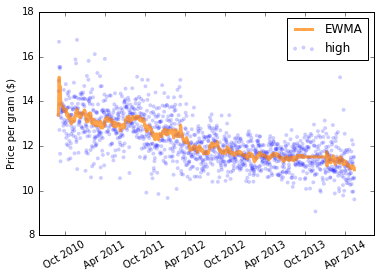

In [20]:
PlotFilled(daily, name)

A drawback of this method is that it understates the noise in the series. We can solve that problem by adding in resampled residuals.

Calculate the residuals obtained on the rest of the dataset between the series and a given point and pick a random one to add to the series to each of the points calculated:

In [14]:
# Code it here

## Serial correlation

As prices vary from day to day, you might expect to see patterns. If the price is high on Monday, you might expect it to be high for a few more days; and if it’s low, you might expect it to stay low. A pattern like this is called **serial correlation**, because each value is correlated with the next one in the series.

To compute serial correlation, we can shift the time series by an interval called a **lag**, and then compute the correlation of the shifted series with the original:

In [ ]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

After the shift, the first lag values are nan, so I use a slice to remove them before computing Corr.

If we apply SerialCorr to the raw price data with lag 1, we find serial correlation 0.48 for the high quality category, 0.16 for medium and 0.10 for low. In any time series with a long-term trend, we expect to see strong serial correlations; for example, if prices are falling, we expect to see values above the mean in the first half of the series and values below the mean in the second half.

In [22]:
filled_dailies = {}
for name, daily in dailies.items():
    filled_dailies[name] = FillMissing(daily, span=30)

In [23]:
for name, filled in filled_dailies.items():            
    corr = thinkstats2.SerialCorr(filled.ppg, lag=1)
    print(name, corr)

high 0.480157057617
medium 0.1736217448
low 0.119991439308


It is more interesting to see if the correlation persists if you subtract away the trend. For example, we can compute the residual of the EWMA and then compute its serial correlation:

In [24]:
for name, filled in filled_dailies.items():            
    corr = thinkstats2.SerialCorr(filled.resid, lag=1)
    print(name, corr)

high -0.0164485711933
medium -0.0181750319436
low 0.0469291300611


In [ ]:
ewma = pd.ewma(reindexed.ppg, span=30)
resid = reindexed.ppg - ewma
corr = SerialCorr(resid, 1)

With lag=1, the serial correlations for the de-trended data are -0.022 for high quality, -0.015 for medium, and 0.036 for low. These values are small, indicating that there is little or no one-day serial correlation in this series.

Run the analysis again with differenst lags of 1, 7, 30 and 365 to see the correlations.

In [25]:
rows = []
for lag in [1, 7, 30, 365]:
    print(lag, end='\t')
    for name, filled in filled_dailies.items():            
        corr = SerialCorr(filled.resid, lag)
        print('%.2g' % corr, end='\t')
    print()

1	-0.016	-0.018	0.047	
7	0.0032	-0.032	-0.019	
30	0.011	-0.0014	-0.017	
365	0.051	0.013	0.026	


In the next section we’ll test whether these correlations are statistically significant (they are not), but at this point we can tentatively conclude that there are no substantial seasonal patterns in these series, at least not with these lags.

## Autocorrelation

If you think a series might have some serial correlation, but you don’t know which lags to test, you can test them all! The **autocorrelation function** is a function that maps from lag to the serial correlation with the given lag. “Autocorrelation” is another name for serial correlation, used more often when the lag is not 1.

StatsModels, which we used for linear regression also provides functions for time series analysis, including acf, which computes the autocorrelation function:

In [39]:
import statsmodels.tsa.stattools as smtsa

In [ ]:
filled = filled_dailies['high']
acf = smtsa.acf(filled.resid, nlags=365, unbiased=True)
print('%0.2g, %.2g, %0.2g, %0.2g, %0.2g' % 
      (acf[0], acf[1], acf[7], acf[30], acf[365]))

`acf` computes serial correlations with lags from 0 through nlags. The unbiased flag tells acf to correct the estimates for the sample size. The result is an array of correlations. If we select daily prices for high quality,
and extract correlations for lags 1, 7, 30, and 365, we can confirm that acf and SerialCorr yield approximately the same results:

In [ ]:
acf[0], acf[1], acf[7], acf[30], acf[365]

With `lag=0`, `acf` computes the correlation of the series with itself, which is always 1.
Plot the autocorrelation function for a lag of 40 days.

In [27]:
def SimulateAutocorrelation(daily, iters=1001, nlags=40):
    """Resample residuals, compute autocorrelation, and plot percentiles.

    daily: DataFrame
    iters: number of simulations to run
    nlags: maximum lags to compute autocorrelation
    """
    # run simulations
    t = []
    for _ in range(iters):
        filled = FillMissing(daily, span=30)
        resid = thinkstats2.Resample(filled.resid)
        acf = smtsa.acf(resid, nlags=nlags, unbiased=True)[1:]
        t.append(np.abs(acf))

    high = thinkstats2.PercentileRows(t, [97.5])[0]
    low = -high
    lags = range(1, nlags+1)
    thinkplot.FillBetween(lags, low, high, alpha=0.2, color='gray')

In [28]:
def PlotAutoCorrelation(dailies, nlags=40, add_weekly=False):
    """Plots autocorrelation functions.

    dailies: map from category name to DataFrame of daily prices
    nlags: number of lags to compute
    add_weekly: boolean, whether to add a simulated weekly pattern
    """
    thinkplot.PrePlot(3)
    daily = dailies['high']
    SimulateAutocorrelation(daily)

    for name, daily in dailies.items():

        if add_weekly:
            daily = AddWeeklySeasonality(daily)

        filled = FillMissing(daily, span=30)

        acf = smtsa.acf(filled.resid, nlags=nlags, unbiased=True)
        lags = np.arange(len(acf))
        thinkplot.Plot(lags[1:], acf[1:], label=name)

To see what the autocorrelation function looks like when there is a seasonal component, I generated simulated data by adding a weekly cycle. Assuming that demand for cannabis is higher on weekends, we might expect the price
to be higher. To simulate this effect, I select dates that fall on Friday or Saturday and add a random amount to the price, chosen from a uniform distribution from `$0 to `$2.

In [16]:
def AddWeeklySeasonality(daily):
    frisat = (daily.index.dayofweek==4) | (daily.index.dayofweek==5)
    fake = daily.copy()
    fake.ppg[frisat] += np.random.uniform(0, 2, frisat.sum())
    return fake

plot the autocorrelation of this new series:

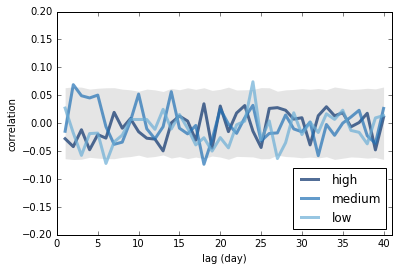

In [30]:
axis = [0, 41, -0.2, 0.2]

PlotAutoCorrelation(dailies, add_weekly=False)
thinkplot.Config(axis=axis, 
                     loc='lower right',
                     ylabel='correlation',
                     xlabel='lag (day)')

`autocorrelation` functions for prices with this simulated seasonality. As expected, the correlations are highest when the lag is a multiple of 7. For high and medium quality, the new correlations are statistically significant. For low quality they are not, because residuals in this category are large; the effect would have to be bigger to be visible through the noise.

Here's what it would look like if there were a weekly cycle.

/home/downey/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


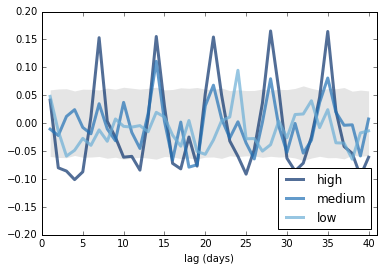

In [31]:
PlotAutoCorrelation(dailies, add_weekly=True)
thinkplot.Config(axis=axis,
                 loc='lower right',
                 xlabel='lag (days)')

## Prediction

Time series analysis can be used to investigate, and sometimes explain, the behavior of systems that vary in time. It can also make predictions.

The linear regressions we used in Section 12.3 can be used for prediction. The RegressionResults class provides predict, which takes a DataFrame containing the explanatory variables and returns a sequence of predictions.
Here’s the code:

In [19]:
def GenerateSimplePrediction(results, years):
    n = len(years)
    inter = np.ones(n)
    d = dict(Intercept=inter, years=years)
    predict_df = pandas.DataFrame(d)
    predict = results.predict(predict_df)
    return predict

In [33]:
def PlotSimplePrediction(results, years):
    predict = GenerateSimplePrediction(results, years)

    thinkplot.Scatter(daily.years, daily.ppg, alpha=0.2, label=name)
    thinkplot.plot(years, predict, color='#ff7f00')
    xlim = years[0]-0.1, years[-1]+0.1
    thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)',
                 loc='upper right')

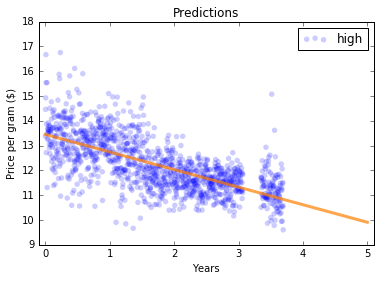

In [34]:
name = 'high'
daily = dailies[name]

_, results = RunLinearModel(daily)
years = np.linspace(0, 5, 101)
PlotSimplePrediction(results, years)

results is a RegressionResults object; years is the sequence of time values we want predictions for. The function constructs a DataFrame, passes it to predict, and returns the result.

If all we want is a single, best-guess prediction, we’re done. But for most purposes it is important to quantify error. In other words, we want to know how accurate the prediction is likely to be.

**In modeling there are three sources of error** we should take into account:

- Sampling error: The prediction is based on estimated parameters, which depend on random variation in the sample. If we run the experiment again, we expect the estimates to vary.

- Random variation: Even if the estimated parameters are perfect, the observed data varies randomly around the long-term trend, and we expect this variation to continue in the future.

- Modeling error: We have already seen evidence that the long-term trend is not linear, so predictions based on a linear model will eventually fail.

Another source of error to consider is unexpected future events. Agricultural prices are affected by weather, and all prices are affected by politics and law. As I write this, cannabis is legal in two states and legal for medical purposes in 20 more. If more states legalize it, the price is likely to go down. But if the federal government cracks down, the price might go up.

Modeling errors and unexpected future events are hard to quantify. Sampling error and random variation are easier to deal with, so we’ll do that first.

To quantify sampling error, I use resampling, as we did in before. As always, the goal is to use the actual observations to simulate what would happen if we ran the experiment again. The simulations are based on the
assumption that the estimated parameters are correct, but the random residuals could have been different. Here is a function that runs the simulations:

In [ ]:
def SimulateResults(daily, iters=101):
    model, results = RunLinearModel(daily)
    fake = daily.copy()
    result_seq = []
    for i in range(iters):
        fake.ppg = results.fittedvalues + Resample(results.resid)
        _, fake_results = RunLinearModel(fake)
        result_seq.append(fake_results)
    
    return result_seq

daily is a DataFrame containing the observed prices; iters is the number of simulations to run.

SimulateResults uses RunLinearModel, to estimate the slope and intercept of the observed values.

Each time through the loop, it generates a “fake” dataset by resampling the residuals and adding them to the fitted values. Then it runs a linear model on the fake data and stores the RegressionResults object.

The next step is to use the simulated results to generate predictions:

In [ ]:
def GeneratePredictions(result_seq, years, add_resid=False):
    n = len(years)
    d = dict(Intercept=np.ones(n), years=years, years2=years**2)
    predict_df = pandas.DataFrame(d)
    predict_seq = []
    
    for fake_results in result_seq:
        predict = fake_results.predict(predict_df)
        if add_resid:
            predict += thinkstats2.Resample(fake_results.resid, n)
        predict_seq.append(predict)
    return predict_seq

GeneratePredictions takes the sequence of results from the previous step, as well as years, which is a sequence of floats that specifies the interval to generate predictions for, and add_resid, which indicates whether it should add resampled residuals to the straight-line prediction. GeneratePredictions iterates through the sequence of RegressionResults and generates a sequence of predictions.

Finally, here’s the code that plots a 90% confidence interval for the predictions:

In [20]:
def PlotPredictions(daily, years, iters=101, percent=90):
    result_seq = SimulateResults(daily, iters=iters)
    p = (100 - percent) / 2
    percents = p, 100-p
    
    predict_seq = GeneratePredictions(result_seq, years, True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color='gray')
    
    predict_seq = GeneratePredictions(result_seq, years, False)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color='gray')

PlotPredictions calls GeneratePredictions twice: once with add_resid=True and again with add_resid=False. It uses PercentileRows to select the 5th and 95th percentiles for each year, then plots a gray region between these bounds.

Use the revious code to plot the calculated predictions:

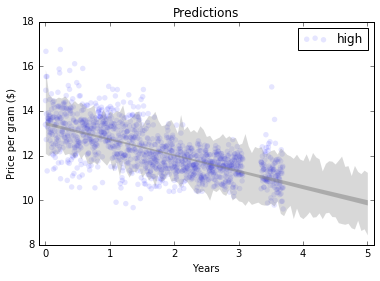

In [38]:
years = np.linspace(0, 5, 101)
thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                   xlabel='Years',
                   xlim=xlim,
                   ylabel='Price per gram ($)')

But there is one more source of uncertainty: how much past data should we use to build the model?

The following function generates a sequence of models based on different amounts of past data.

In [39]:
def SimulateIntervals(daily, iters=101, func=RunLinearModel):
    """Run simulations based on different subsets of the data.

    daily: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data

    returns: list of result objects
    """
    result_seq = []
    starts = np.linspace(0, len(daily), iters).astype(int)

    for start in starts[:-2]:
        subset = daily[start:]
        _, results = func(subset)
        fake = subset.copy()

        for _ in range(iters):
            fake.ppg = (results.fittedvalues + 
                        thinkstats2.Resample(results.resid))
            _, fake_results = func(fake)
            result_seq.append(fake_results)

    return result_seq

And this function plots the results.

In [40]:
def PlotIntervals(daily, years, iters=101, percent=90, func=RunLinearModel):
    """Plots predictions based on different intervals.

    daily: DataFrame of daily prices
    years: sequence of times (in years) to make predictions for
    iters: number of simulations
    percent: what percentile range to show
    func: function that fits a model to the data
    """
    result_seq = SimulateIntervals(daily, iters=iters, func=func)
    p = (100 - percent) / 2
    percents = p, 100-p

    predict_seq = GeneratePredictions(result_seq, years, add_resid=True)
    low, high = thinkstats2.PercentileRows(predict_seq, percents)
    thinkplot.FillBetween(years, low, high, alpha=0.2, color='gray')

Here's what the high quality category looks like if we take into account uncertainty about how much past data to use.

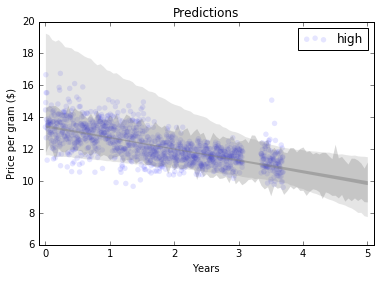

In [41]:
name = 'high'
daily = dailies[name]

thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
PlotIntervals(daily, years)
PlotPredictions(daily, years)
xlim = years[0]-0.1, years[-1]+0.1
thinkplot.Config(title='Predictions',
                 xlabel='Years',
                 xlim=xlim,
                 ylabel='Price per gram ($)')

The lighter region shows a 90% confidence interval for prediction error, which is the sum of sampling error and random variation.

These regions quantify sampling error and random variation, but not modeling error. In general modeling error is hard to quantify, but in this case we can address at least one source of error, unpredictable external events.

The regression model is based on the assumption that the system is **stationary**; that is, that the parameters of the model don’t change over time. Specifically, it assumes that the slope and intercept are constant, as well as
the distribution of residuals.

But looking at the moving averages in Figure 12.3, it seems like the slope changes at least once during the observed interval, and the variance of the residuals seems bigger in the first half than the second.

As a result, the parameters we get depend on the interval we observe. To see how much effect this has on the predictions, we can extend SimulateResults to use intervals of observation with different start and end dates. My implementation is in timeseries.py.

The model based on the entire interval has positive slope, indicating that prices were increasing. But the most recent interval shows signs of decreasing prices, so models based on the most recent data have negative slope. As a
result, the widest predictive interval includes the possibility of decreasing prices over the next year.

## Further reading

Time series analysis is a big topic; this chapter has only scratched the surface. An important tool for working with time series data is autoregression, which I did not cover here, mostly because it turns out not to be useful for the example data I worked with.

But once you have learned the material in this chapter, you are well prepared to learn about autoregression. One resource I recommend is Philipp Janert’s xbook, Data Analysis with Open Source Tools, O’Reilly Media, 2011. His
chapter on time series analysis picks up where this one leaves off.